In [37]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun  7 16:03:09 2018
@author: KRUEGKJ
transformers.py
"""
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from scipy.stats import norm

import sys
sys.path.append('./lib')
sys.path.append('./utilities')

from oscillator_studies import *
from ta_volume_studies import *
from ta_momentum_studies import *
from ta_volatility_studies import *


class Transformers:
    """Various signal transformation functions"""

    def zScore_transform(self, df, zs_lb, ind, feature_dict):
        """Handles zScore functions by creating indicator name and
            sending request to zScore function. Z-score statistic
            centered on 0.0.

            Args:
                df: Dataframe containing indicator
                zs_lb: Lookback period(int)
                ind: Indicator name to be transformed
                feature_dict: Dictionary of added features
            Return:
                Dataframe comtaining new column with transformed signal
                feature_dict: Append entry with colname
            Usage:
                dataSet, feature_dict = transf.zScore_transform(dataSet,
                lb, indName, feature_dict)
        """
        #loop through ind_list
        indName = str(ind)+'_zScore_'+str(zs_lb)
        df[indName] = self.zScore(df[ind], zs_lb)
        feature_dict[indName] = 'Keep'
        return df, feature_dict

    def zScore(self, p, lb):
        """Used by zScore_transform for zScore calculation
            Args:
                p: the series having its z-score computed.
                lb: the lookback period, an integer.
                    the length used for the average and standard deviation.
                    typical values 3 to 10.
            Return:
                Return is a numpy array with values as z-scores
        """
        nrows = p.shape[0]
        st = np.zeros(nrows)
        ma = np.zeros(nrows)
        # use the pandas sliding window functions.
        st = p.rolling(window=lb, center=False).std()
        ma = p.rolling(window=lb, center=False).mean()
        z = np.zeros(nrows)
        for i in range(lb, nrows):
            z[i] = (p[i] - ma[i]) / st[i]
        return z

    def add_lag(self, df, lag_var, lags, feature_dict):
        """Add lag to any time-based series

            Args:
                df: dataframe column
                lag_var: indicator to be lagged
                lags: number of lags to add
                feature_dict: Dictionary of added features
            Returns:
                Dataframe with lagged indicator added
                feature_dict: Append entry with colname
            Usage:
                dataSet, feature_dict = transf.add_lag(
                        dataSet,
                        lag_var,
                        lags,
                        feature_dict)
        """
        for i in range(0, lags):
            df[lag_var + "_lag" + str(i+1)] = df[lag_var].shift(i+1)
            feature_dict[lag_var + "_lag" + str(i+1)] = 'Keep'
        return df, feature_dict

    def centering(self, df, col, feature_dict, lb=14, type='median'):
        """Subtract a historical median from signal

            Args:
                dataSet: Time series dataset
                col: Column name to be centered
                feature_dict: Dictionary of added features
                lb(int): lookback period
                type: default is median, could add more types in future
            Returns:
                dataSet: Dataset with new feature generated.
                feature_dict: Append entry with colname
            Usage:
                dataSet, feature_dict = transf.centering(
                        dataSet,
                        'ChaikinAD',
                        feature_dict,
                        14)
        """
        col_name = str(col) + '_Centered'
        feature_dict[col_name] = 'Keep'
        df[col_name] = df[col]
        if type == 'median':
            rm = df[col].rolling(window=lb, center=False).median()
            df[col_name] = df[col] - rm
        return df, feature_dict

    def scaler(self, df, col, type, feature_dict):
        """Scale - Use when sign and magnitude is of
                    paramount importance.
                    Scale accoring to historical volatility
                    defined by interquartile range.
            Args:
                df: Signal to be centered
                col: Column name to be centered
                feature_dict: Dictionary of added features
                lb(int): lookback period
                type: default is median, col
            Returns:
                dataSet: Dataset with new feature generated.
                feature_dict: Append entry with colname
            To Update: Expand code to call other scalers from sci-kit
        """
        col_name = str(col) + '_Scaled'
        feature_dict[col_name] = 'Keep'
        df[col_name] = df[col]
        # current only coded to use RobustScaler
        scaler = RobustScaler(quantile_range=(25, 75))
        df[[col_name]] = scaler.fit_transform(df[[col_name]])
        return df, feature_dict

    def normalizer(self, dataSet, colname, n, 
                   feature_dict, mode = 'scale', linear = False):
        """
             It computes the normalized value on the stats of n values
             ( Modes: total or scale ) using the formulas from the book
             "Statistically sound machine learning..." (Aronson and Masters)
             but the decission to apply a non linear scaling is left to the
             user. It's scale is supposed to be -100 to 100.
             -100 to 100 df is an imput DataFrame. it returns also a
             DataFrame, but it could return a list.

            Args:
                dataSet: dataframe cotaining signal to be normalized
                colname: Column name to be normalized
                n: number of data points to get the mean and the
                   quartiles for the normalization
                feature_dict: Dictionary of added features
                mode: scale: scale, without centering.
                        total: center and scale.
                linear: non-linear or linear scaling
            Returns:
                dataSet: Dataset with new feature generated.
                feature_dict: Append entry with colname
        """
        temp =[]
        new_colname = str(colname) + '_Normalized'
        feature_dict[new_colname] = 'Keep'
        df = dataSet[colname]
        for i in range(len(df))[::-1]:
            if i  >= n:
                # there will be a traveling norm until we reach the initial n
                # values. Those values will be normalized using the last
                # computed values of F50,F75 and F25
                F50 = df[i-n:i].quantile(0.5)
                F75 =  df[i-n:i].quantile(0.75)
                F25 =  df[i-n:i].quantile(0.25)
            if linear == True and mode == 'total':
                 v = 50 * ((df.iloc[i] - F50) / (F75 - F25)) - 50
            elif linear == True and mode == 'scale':
                 v =  25 * df.iloc[i] / (F75 - F25) -50
            elif linear == False and mode == 'scale':
                 v = 100 * norm.cdf(0.5 * df.iloc[i] / (F75 - F25)) - 50
            else:
                # even if strange values are given, it will perform full
                # normalization with compression as default
                v = norm.cdf(50*(df.iloc[i]-F50)/(F75-F25))-50
            temp.append(v)
        dataSet[new_colname] = temp[::-1]
        return  dataSet, feature_dict



In [144]:
if __name__ == "__main__":
    from plot_utils import *
    from retrieve_data import *
    from indicators import *
    from ta_volume_studies import *

    dataLoadStartDate = "2014-04-01"
    dataLoadEndDate = "2018-04-01"
    issue = "TLT"
    feature_dict = {}

    taLibVolSt = TALibVolumeStudies()

    dSet = DataRetrieve()
    dataSet = dSet.read_issue_data(issue)
    dataSet = dSet.set_date_range(dataSet, dataLoadStartDate,dataLoadEndDate)
   
    oscSt = OscialltorStudies()
    dataSet['DPO'], feature_dict = oscSt.detrend_PO(dataSet.Pri,
                                                    10,
                                                    feature_dict
                                                    )
    taLibMomSt = TALibMomentumStudies()
    dataSet['RSI'], feature_dict = taLibMomSt.RSI(dataSet.Pri.values,
                                                  20,
                                                  feature_dict
                                                  )
    dataSet['ROC'], feature_dict = taLibMomSt.rate_OfChg(dataSet.Pri.values,
                                                         10,
                                                         feature_dict
                                                         )
    vStud = TALibVolatilityStudies()
    dataSet['ATR'], feature_dict = vStud.ATR(dataSet.High.values,
                                             dataSet.Low.values,
                                             dataSet.Pri.values,
                                             20,
                                             feature_dict
                                             )
    zScore_lb = 3
    transf = Transformers()
    transfList = ['ATR','DPO','ROC']
    for i in transfList:
        dataSet, feature_dict = transf.zScore_transform(dataSet, zScore_lb, i, feature_dict)

    # Plot price and indicators
    startDate = "2015-02-01"
    endDate = "2015-06-30"
    plotDataSet = dataSet.ix[startDate:endDate]

Successfully retrieved data series for TLT


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [210]:
    # Set up plot dictionary
    plot_dict = {}
    

In [221]:
    plot_dict['Issue'] = issue
    #for i in transfList:
    #    plot_dict.setdefault('Plot_Vars',[]).append(i)
    plot_dict['Plot_Vars'] = ['ROC']
    #plot_dict['Plot_Vars'] = [plot_dict['Plot_Vars'],'RSI']
    plot_dict['Volume'] = 'Yes'

In [222]:
print(plot_dict)

{'Issue': 'TLT', 'Plot_Vars': ['ROC'], 'Volume': 'Yes'}


In [223]:
key_to_value_lengths = {k:len(v) for k, v in plot_dict.items()}
print(key_to_value_lengths)
key_to_value_lengths['Plot_Vars']

{'Issue': 3, 'Plot_Vars': 1, 'Volume': 3}


1

In [224]:
print(plot_dict)

{'Issue': 'TLT', 'Plot_Vars': ['ROC'], 'Volume': 'Yes'}


In [225]:
def price_Ind_Vol_Plot(plot_dict, df):
    # Subplots are organized in a Rows x Cols Grid
    key_to_value_lengths = {k:len(v) for k, v in plot_dict.items()}
    print(key_to_value_lengths)
    key_to_value_lengths['Plot_Vars']
    subplot_len = key_to_value_lengths['Plot_Vars']
    print(subplot_len)
    if plot_dict['Volume']=='Yes':
        total_rows = 2 + subplot_len
    else:
        total_rows = 1 + subplot_len

    Cols = 1
    
    N = len(df)
    ind = np.arange(N)  # the evenly spaced plot indices

    def format_date(x, pos=None):
        thisind = np.clip(int(x + 0.5), 0, N - 1)
        return df.Date[thisind].strftime('%Y-%m-%d')
    
    fig = plt.figure(1,figsize=(14,total_rows*2))
    plt.subplots_adjust(hspace=0.05)
    
    cnt = 0
    for n in range(1,total_rows+1):
        if n==1:
            ax = fig.add_subplot(total_rows,Cols,1)
            ax.plot(ind, df['Pri'], label=issue)
        elif n < subplot_len+2:
            ax = fig.add_subplot(total_rows,Cols,n,sharex=ax)
            ax.plot(ind, df[plot_dict['Plot_Vars'][cnt]], label=plot_dict['Plot_Vars'][cnt])
            cnt += 1
        else: # add Volume plot if requested
            ax = fig.add_subplot(total_rows,Cols,n)
            ax.bar(ind, df['Volume'], label='Volume')
        
        ax.grid(b=True, which='major', color='k', linestyle='-')
        ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
        ax.label_outer()
        ax.legend(loc='upper left', frameon=True, fontsize=8)
        ax.minorticks_on()
        #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))

plt.show()

{'Issue': 3, 'Plot_Vars': 1, 'Volume': 3}
1


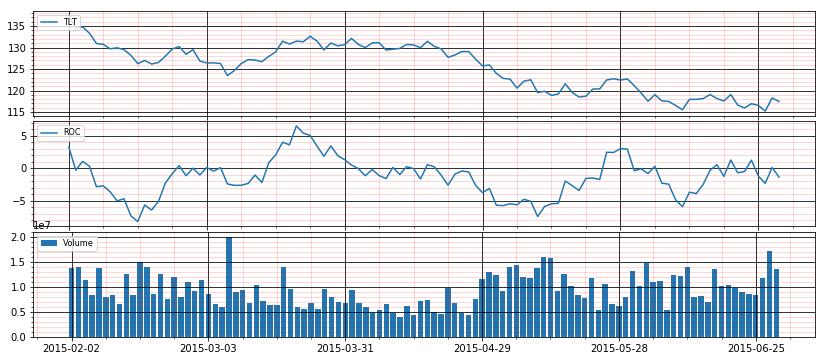

In [226]:
price_Ind_Vol_Plot(plot_dict, plotDataSet)

In [74]:
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known
Tot = 5
Cols = 1

# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index
Position = range(1,Tot + 1)

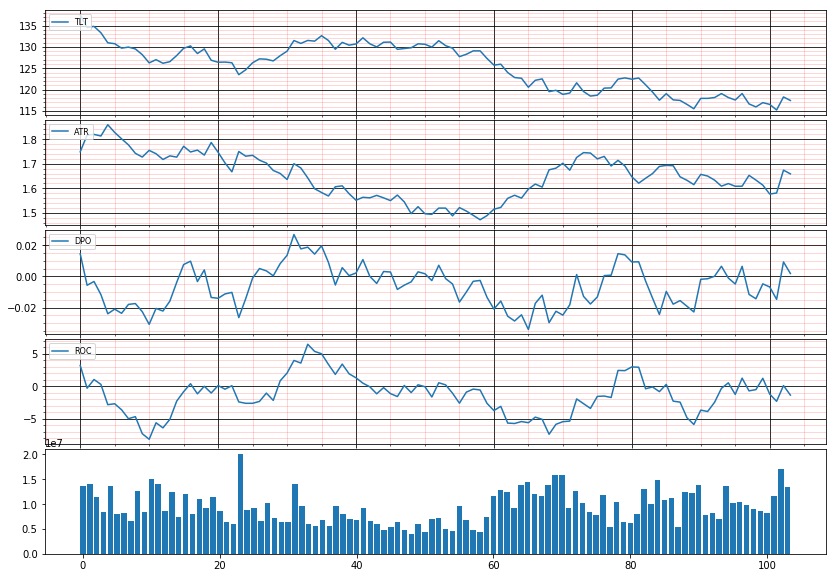

In [106]:
fig = plt.figure(1,figsize=(14,Rows*2))
plt.subplots_adjust(hspace=0.05)
subplot_len = len(plot_dict['Plot_Vars'])

cnt = 0

for n in range(1,subplot_len+3):
    ax.grid(b=True, which='major', color='k', linestyle='-')
    ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
    ax.label_outer()
    ax.legend(loc='upper left', frameon=True, fontsize=8)
    ax.minorticks_on()
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    
    if n==1:
        ax = fig.add_subplot(Rows,Cols,1)
        ax.plot(ind, rsiDataSet['Pri'], label=issue)
    elif n < subplot_len+2:
        ax = fig.add_subplot(Rows,Cols,n,sharex=ax)
        ax.plot(ind, rsiDataSet[plot_dict['Plot_Vars'][cnt]], label=plot_dict['Plot_Vars'][cnt])
        cnt += 1
    else:
        ax = fig.add_subplot(Rows,Cols,n)
        ax.bar(ind, rsiDataSet['Volume'], label='Volume')
        


plt.show()

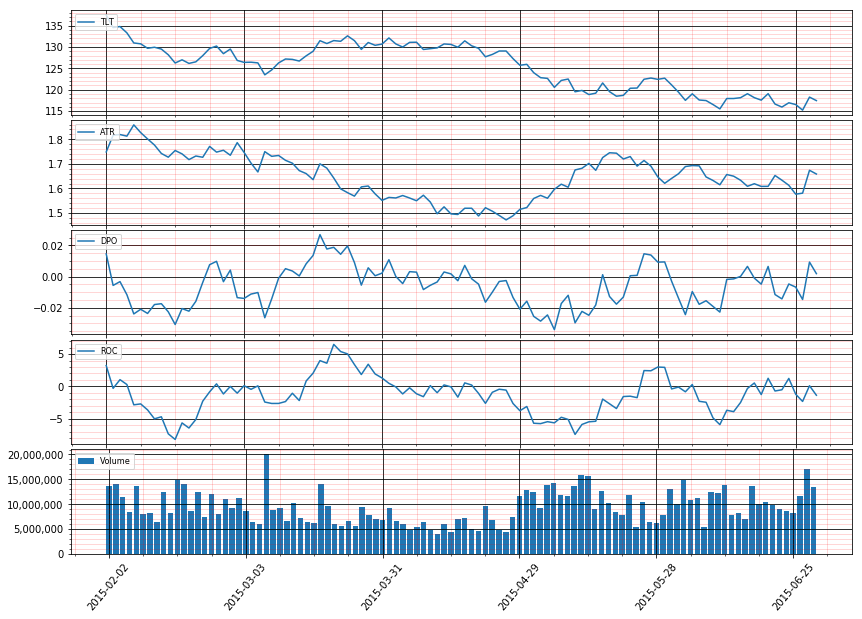

In [105]:
fig = plt.figure(1,figsize=(14,Rows*2))

ax = fig.add_subplot(Rows,Cols,1)
ax.plot(ind, rsiDataSet['Pri'], label=issue)
ax.grid(b=True, which='major', color='k', linestyle='-')
ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
ax.label_outer()
ax.legend(loc='upper left', frameon=True, fontsize=8)
ax.minorticks_on()

subplot_len = len(plot_dict['Plot_Vars'])

for k in range(0,subplot_len):
    ax = fig.add_subplot(Rows,Cols,k+2,sharex=ax)
    ax.plot(ind, rsiDataSet[plot_dict['Plot_Vars'][k]])
    ax.grid(b=True, which='major', color='k', linestyle='-')
    ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
    ax.label_outer()
    ax.legend(loc='upper left', frameon=True, fontsize=8)
    ax.minorticks_on()
    
ax = fig.add_subplot(Rows,Cols,k+3)
ax.bar(ind, rsiDataSet['Volume'], label='Volume')

ax.grid(b=True, which='major', color='k', linestyle='-')
ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
ax.label_outer()
ax.legend(loc='upper left', frameon=True, fontsize=8)
ax.minorticks_on()
#ax.autoscale_view()
ax.tick_params(axis='x', rotation=50)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
plt.subplots_adjust(hspace=0.05)
plt.show()

In [ ]:
    numSubPlots = 8
    # format the ticks
    fig, axes = plt.subplots(numSubPlots,1, figsize=(10,numSubPlots*2), sharex=True)
    #fig, axes = plt.subplots(8,1, figsize=(15,8), sharex=True)
    axes[0].plot(rsiDataSet['Pri'], label=issue)
    axes[1].plot(rsiDataSet['RSI'], label='RSI');
    axes[2].plot(rsiDataSet['ROC'], label='ROC');
    axes[3].plot(rsiDataSet['ROC_zScore_'+str(zScore_lb)], label='ROC_zScore');
    axes[4].plot(rsiDataSet['DPO'], label='DPO');
    axes[5].plot(rsiDataSet['DPO_zScore_'+str(zScore_lb)], label='DPO_zScore');
    axes[6].plot(rsiDataSet['ATR'], label='ATR');
    axes[7].plot(rsiDataSet['ATR_zScore_'+str(zScore_lb)], label='ATR_zScore');

    plt.subplots_adjust(hspace=0)
    for ax in axes:
        ax.label_outer()
        ax.legend(loc='upper left', frameon=True, fontsize=8)
        ax.grid(True, which='both')
        fig.autofmt_xdate()
        ax.xaxis_date()
        ax.autoscale_view()
        ax.grid(b=True, which='major', color='k', linestyle='-')
        ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
        ax.minorticks_on()
        ax.tick_params(axis='y',which='minor',bottom='off')


In [ ]:
    #### testing Lag
    lag_var = 'Pri'
    lags = 5
    dataSet, feature_dict = transf.add_lag(dataSet,
                                           lag_var,
                                           lags,
                                           feature_dict
                                           )

    # Plot price and lags
    startDate = "2015-02-01"
    endDate = "2015-04-30"
    lagDataSet = dataSet.ix[startDate:endDate]

    numSubPlots = 5
    # format the ticks
    fig, axes = plt.subplots(numSubPlots,1, figsize=(10,numSubPlots*2), sharex=True)

    axes[0].plot(lagDataSet['Pri'], label=issue)
    axes[1].plot(lagDataSet['Pri_lag1'], label='Pri_lag1');
    axes[2].plot(lagDataSet['Pri_lag2'], label='Pri_lag2');
    axes[3].plot(lagDataSet['Pri_lag3'], label='Pri_lag3');
    axes[4].plot(lagDataSet['Pri_lag4'], label='Pri_lag4');

    # Bring subplots close to each other.
    plt.subplots_adjust(hspace=0.1)

    #plt.legend((issue,'RSI','ROC','DPO','ATR'),loc='upper left')
    # Hide x labels and tick labels for all but bottom plot.
    for ax in axes:
            ax.label_outer()
            ax.legend(loc='upper left', frameon=True, fontsize=8)
            ax.grid(True, which='both')
            fig.autofmt_xdate()
            ax.xaxis_date()
            ax.autoscale_view()
            ax.grid(b=True, which='major', color='k', linestyle='-')
            ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
            ax.minorticks_on()
            ax.tick_params(axis='y',which='minor',bottom='off')

    dataSet['ChaikinAD'], feature_dict = taLibVolSt.ChaikinAD(
            dataSet.High.values,
            dataSet.Low.values,
            dataSet.Pri.values,
            dataSet.Volume,
            feature_dict)

    dataSet, feature_dict = transf.scaler(
            dataSet,
            'ChaikinAD',
            'robust',
            feature_dict)

    dataSet, feature_dict = transf.centering(
            dataSet,
            'ChaikinAD',
            feature_dict,
            14)

    dataSet, feature_dict = transf.normalizer(
            dataSet,
            'ChaikinAD',
            200,
            feature_dict,
            mode='scale',
            linear=False)

    startDate = "2015-10-01"
    endDate = "2016-06-30"
    rsiDataSet = dataSet.ix[startDate:endDate]
    plt.figure(figsize=(15,10))
    horizplots = 7
    top = plt.subplot2grid((horizplots,4), (0, 0), rowspan=2, colspan=4)
    middle = plt.subplot2grid((horizplots,4), (2, 0), rowspan=1, colspan=4)
    middle2 = plt.subplot2grid((horizplots,4), (3, 0), rowspan=1, colspan=4)
    middle3 = plt.subplot2grid((horizplots,4), (4, 0), rowspan=1, colspan=4)
    middle4 = plt.subplot2grid((horizplots,4), (5, 0), rowspan=1, colspan=4)
    bottom = plt.subplot2grid((horizplots,4), (6, 0), rowspan=1, colspan=4)

    top.plot(rsiDataSet.index, rsiDataSet['Pri'], 'k-', markersize=3,label=issue)
    middle.plot(rsiDataSet.index, rsiDataSet['ChaikinAD'], 'g-')
    middle2.plot(rsiDataSet.index, rsiDataSet['ChaikinAD_Scaled'], '-')
    middle3.plot(rsiDataSet.index, rsiDataSet['ChaikinAD_Centered'], 'b-')
    middle4.plot(rsiDataSet.index, rsiDataSet['ChaikinAD_Normalized'], 'b-')
    bottom.bar(rsiDataSet.index, rsiDataSet['Volume'], label='Volume')

    plt.subplots_adjust(hspace=0.05)
    # set the labels
    top.axes.get_xaxis().set_visible(True)
    top.set_title('TLT')
    top.set_ylabel('Closing Price')
    bottom.set_ylabel('Volume')

    #top.axhline(y=30, color='red', linestyle='-', alpha=0.4)
    #top.axhline(y=70, color='blue', linestyle='-', alpha=0.4)
    middle.axhline(y=0, color='black', linestyle='-', alpha=0.4)

    for ax in top, middle, middle2, middle3, middle4, bottom:
                    ax.label_outer()
                    ax.legend(loc='upper left', frameon=True, fontsize=12)
                    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
                    ax.grid(True, which='both')
                    ax.xaxis_date()
                    ax.autoscale_view()
                    ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.6)
                    ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
                    ax.minorticks_on()
